# Tutorial 4: Mouse Olfactory Bulb (Stereo-seq)


<p align="left">
  <img src="../../_static/MObulb.png" width="150">
</p>
> This tutorial demonstrates how to identify spatial domains on Setereo-seq data from mouse olfactory bulb by SemanticST.


## Import necessary packages

In [1]:
from sklearn import metrics
import torch
import copy
import os
import random
import numpy as np
from semanticst.loading_batches import PrepareDataloader
from semanticst.loading_batches import Dataloader
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import torch.utils.data as data
from semanticst.main import Config

/home/roxana/anaconda3/envs/semanticst3/lib/python3.9/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


## Read data and import device

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"You are using *{device}*")
BASE_PATH = Path('/home/roxana/Projects/Data/5.Mouse_Olfactory/filtered_feature_bc_matrix.h5ad')
spot_paths= Path(f'{BASE_PATH}')


You are using *cpu*


In [3]:
dataset="mouse olfactory bulb"
adata = sc.read_h5ad(spot_paths)
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=20)
sc.pp.filter_genes(adata, min_cells=50)
print(adata)

AnnData object with n_obs × n_vars = 19047 × 14376
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'


(6005.190789473684, 12428.6600877193, 9986.774763741741, 15062.302776957435)

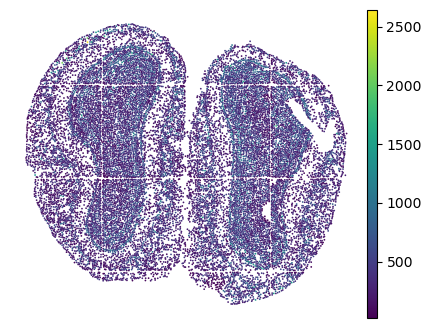

In [4]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

## Train the model
Available data types: ''Xenium', 'Visium', 'Stereo', Slide.
<br>
It is essential to specify the type of ST data, as different ST technologies require distinct preprocessing steps. Additionally, you have the option to select between mini-batch training for large datasets and full dataset training for smaller ones, ensuring efficient data processing and model performance.</h3>

In [4]:
dtype = "Stereo"  
config=Config(device=device,dtype=dtype, use_mini_batch=False)
from semanticst.SemanticST_main import Semantic as Trainer
config_used = copy.copy(config)
model = Trainer(adata,config)  
adata=model.train()  # Train the model


🚀 Welcome to SemanticST! 🚀

📢 Recommendation: If your dataset contains more than 40000 spots or cells, we suggest using **mini-batch training** for efficiency.

✅ Using Full Dataset Training (No Mini-Batching). 🔥


/home/roxana/anaconda3/envs/semanticst3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Begin to train ST data...
building sparse Matrix
127939


Learning Semantic graphs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:38<00:00,  6.53epoch/s]


Semantic Graph Learning Completed


Feature Learning Epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [35:23<00:00,  2.12s/it]


## Clustering 
    - Leiden 
    - Louvain

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, random_state=1) 
embedding = pca.fit_transform(adata.obsm['emb_decoder'].copy())
adata.obsm['emb_pca'] = embedding
sc.pp.neighbors(adata, use_rep='emb_pca')
sc.tl.umap(adata)

In [ ]:
sc.tl.louvain(adata, random_state=0,resolution=1)

In [7]:
sc.tl.leiden(adata, random_state=0, resolution=1)

/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


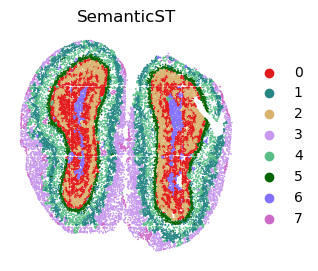

In [27]:
adata.uns['louvain_colors'] =  ["#E31A1C","#268785","#DAB370","#C798EE","#59BE86","#006400","#8470FF",
            "#CD69C9"]
plt.rcParams["figure.figsize"] = (3, 3)
fig, ax = plt.subplots()
sc.pl.embedding(adata, basis="spatial", color="louvain",s=6,palette=adata.uns['louvain_colors'], ax=ax,show=False, title='SemanticST')
plt.axis('off')
fig.savefig("sEMANTIC_seqfish_lov1_mouse_brain.png", dpi=600,bbox_inches='tight')
plt.show()

## Layers's marker genes 


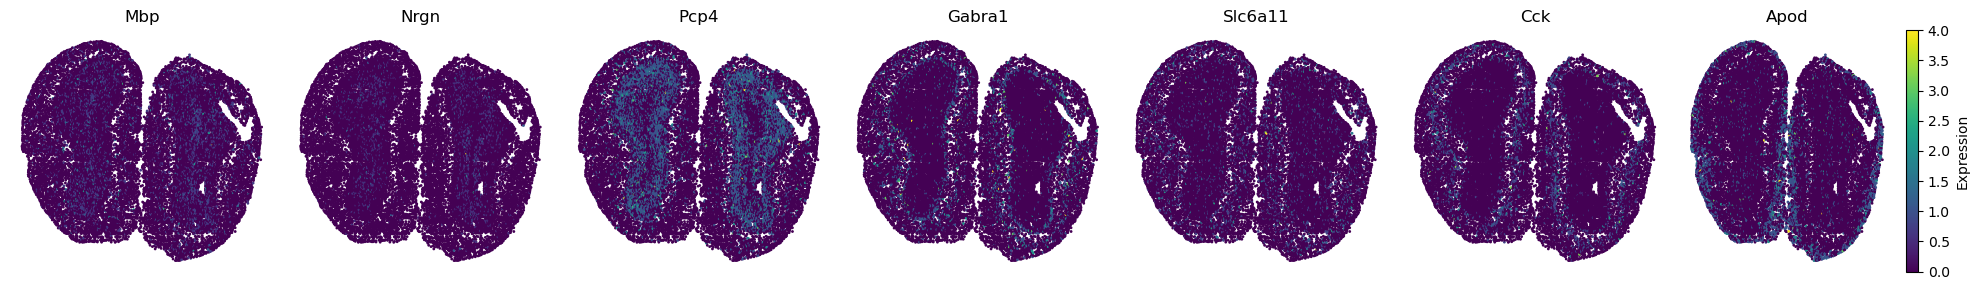

In [7]:
import matplotlib.pyplot as plt
from scipy.sparse import issparse

# Define the list of marker genes you want to plot
marker_genes = ['Mbp', 'Nrgn', 'Pcp4', 'Gabra1', 'Slc6a11', 'Cck', 'Apod']
adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]
# Create a figure with subplots - one for each marker gene
fig, axes = plt.subplots(1, len(marker_genes), figsize=(20, 3))  # Adjust the figsize as needed

for i, gene in enumerate(marker_genes):
    # Check if the gene is in the dataset
    if gene in adata.var_names:
        # Extract the expression values for the gene
        gene_expression = adata[:, gene].X

        # If the data is stored as a sparse matrix, convert it to a dense array
        if issparse(gene_expression):
            gene_expression = gene_expression.toarray().flatten()
        else:
            gene_expression = gene_expression.flatten()

        # Invert the y-axis of the spatial coordinates for visualization (if needed)
        spatial_coords = np.copy(adata.obsm['spatial'])
        spatial_coords[:, 1] = -1 * spatial_coords[:, 1]

        # Create the scatter plot using matplotlib for the current gene
        ax = axes[i]
        scatter = ax.scatter(spatial_coords[:, 0], spatial_coords[:, 1],
                             c=gene_expression, cmap='viridis', s=1)
        ax.set_title(gene)
        
        ax.axis('off')
        
        # Add a color bar to each subplot if desired
        # fig.colorbar(scatter, ax=ax, label='Expression Level')
    else:
        axes[i].text(0.5, 0.5, "Gene '{}' not found".format(gene), 
                     transform=axes[i].transAxes,
                     horizontalalignment='center', verticalalignment='center')
        axes[i].axis('off')
plt.colorbar(scatter, label='Expression')
# Adjust the layout so that subplots fit into the figure area
plt.tight_layout()
#plt.savefig("MARKERS_stereoseq.png", dpi=600,bbox_inches='tight')
# Show the plot
plt.show()


## Clustering with mclust

In [39]:
n_cluster=7
tool = 'mclust' # mclust, leiden, and louvain

# clustering
from semanticst.utils import clustering
clustering(adata,seed=1, n_clusters=n_cluster, method=tool,key='emb_decoder')


fitting ...
  |======================================================================| 100%


/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


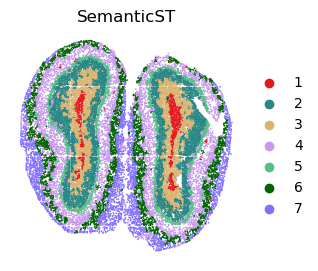

In [54]:
plt.rcParams["figure.figsize"] = (3,3)
plot_color=["#E31A1C","#268785","#DAB370","#C798EE","#59BE86","#006400","#8470FF",
            "#CD69C9"]

sc.pl.embedding(adata, basis="spatial", color="domain",s=6,palette=plot_color, show=False, title='SemanticST')
plt.axis('off')
plt.savefig("sEMANTIC_seqfish_mclust_mouse_brain.png", dpi=600,bbox_inches='tight')
plt.show()

/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/tower2/anaconda3/envs/new_stellar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


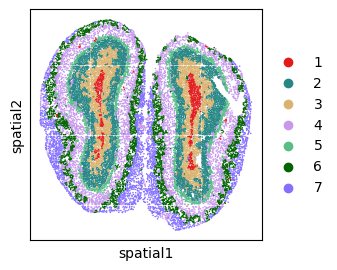

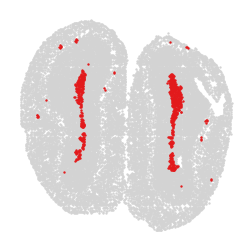

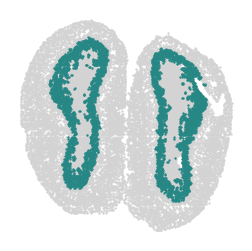

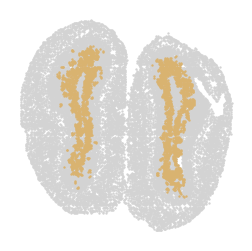

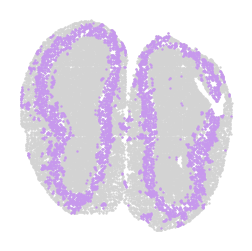

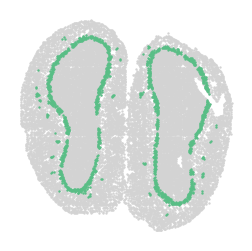

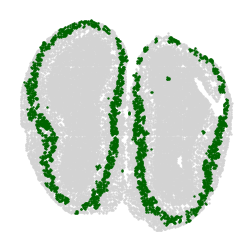

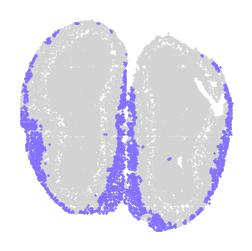

In [52]:
import matplotlib.pyplot as plt
import scanpy as sc

# Assuming adata is already defined and preprocessed
adata.obsm['spatial'][:, 1] = -1 * adata.obsm['spatial'][:, 1]

plt.rcParams["figure.figsize"] = (3,3)

# Define your custom color palette
plot_color=["#E31A1C","#268785","#DAB370","#C798EE","#59BE86","#006400","#8470FF",
            "#CD69C9"]

# Ensure unique_labels order matches the intended color assignment
unique_labels = sorted(adata.obs['domain'].unique())

# Explicitly map labels to colors
label_to_color = {label: plot_color[i % len(plot_color)] for i, label in enumerate(unique_labels)}

# Apply the color mapping directly for the combined plot
sc.pl.embedding(adata, basis="spatial",
                color="domain",
                s=5,
                palette=label_to_color,  # Use the label_to_color mapping here directly
                title="",
                show=False)

# Plot each cluster with consistent coloring
for label in unique_labels:
    fig, ax = plt.subplots()

    # Plot all cells in light gray
    ax.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], 
               c='lightgray', s=0.5)

    # Overlay the cells of the current label in their respective color
    label_indices = adata.obs['domain'] == label
    ax.scatter(adata.obsm['spatial'][label_indices, 0], 
               adata.obsm['spatial'][label_indices, 1], 
               c=[label_to_color[label]], s=0.5)  # Ensure color is in a list for consistency

    ax.axis('off')
    plt.savefig(f"cluster_{label}_plot.png", dpi=300, bbox_inches='tight')
    plt.show()
